In [3]:
import numpy as np
import pandas as pd
data_path = "../Dataset/final_df.xlsx"
df = pd.read_excel(data_path)
df.head(80)

,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,no_of_stops,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef
0,0,841,20,1,1,98.109,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
1,1,841,20,2,1,93.006,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
2,2,841,20,3,1,92.713,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
3,3,841,20,4,1,92.803,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
4,4,841,20,5,1,92.342,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,841,1,18,2,91.823,1.0,3.0,2.0,85.384,...,NaN,NaN,3,58,5392.556,1,2011,1,Australian Grand Prix,hamilton
76,76,841,1,19,2,91.400,1.0,3.0,2.0,85.384,...,NaN,NaN,3,58,5392.556,1,2011,1,Australian Grand Prix,hamilton
77,77,841,1,20,2,91.194,1.0,3.0,2.0,85.384,...,NaN,NaN,3,58,5392.556,1,2011,1,Australian Grand Prix,hamilton
78,78,841,1,21,2,91.212,1.0,3.0,2.0,85.384,...,NaN,NaN,3,58,5392.556,1,2011,1,Australian Grand Prix,hamilton


In [4]:
df.columns

Index(['Unnamed: 0', 'raceId', 'driverId', 'lap', 'lap_position', 'lap_time',
       'constructorId', 'number', 'quali_position', 'q1', 'q2', 'q3',
       'no_of_stops', 'pit_stop_duration', 'result_position', 'total_laps',
       'total_time', 'statusId', 'year', 'round', 'grand_prix_name',
       'driverRef'],
      dtype='object')

In [5]:
df["lap_time"] = df["lap_time"].astype(float)

df[df["lap_time"]>300].shape


(438, 22)

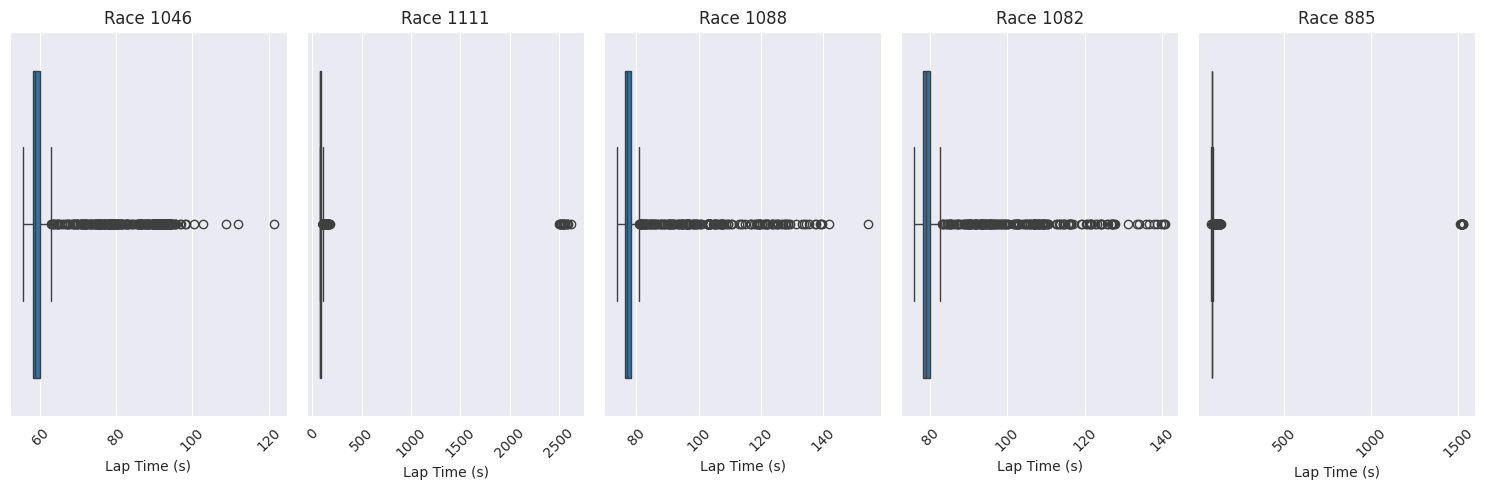

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
top_races = df['raceId'].value_counts().index[:5]

plt.figure(figsize=(15, 5))
for i, race in enumerate(top_races, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(x=df[df['raceId'] == race]['lap_time'])
    plt.title(f'Race {race}')
    plt.xticks(rotation=45)
    plt.xlabel('Lap Time (s)')
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd

def impute_race_outliers(df, iqr_multiplier=1.5):
    """
    Impute lap time outliers within each race using the driver's median lap time for that race.

    Parameters:
        df (pd.DataFrame): Input dataframe containing race data
        iqr_multiplier (float): Multiplier for IQR outlier detection (default: 1.5)

    Returns:
        pd.DataFrame: Dataframe with outliers imputed
    """

    # Make a copy to avoid modifying original
    imputed_df = df.copy()

    # Calculate per-race bounds
    race_stats = (
        imputed_df.groupby('raceId')['lap_time']
        .agg(['median', lambda x: x.quantile(0.25)])
        .rename(columns={'median': 'race_median', '<lambda_0>': 'q1'})
    )
    race_stats['q3'] = (
        imputed_df.groupby('raceId')['lap_time']
        .quantile(0.75)
    )
    race_stats['iqr'] = race_stats['q3'] - race_stats['q1']
    race_stats['lower_bound'] = race_stats['q1'] - iqr_multiplier * race_stats['iqr']
    race_stats['upper_bound'] = race_stats['q3'] + iqr_multiplier * race_stats['iqr']

    # Calculate driver's median lap time per race
    driver_medians = (
        imputed_df.groupby(['raceId', 'driverId'])['lap_time']
        .median()
        .reset_index()
        .rename(columns={'lap_time': 'driver_median'})
    )

    # Merge bounds and medians
    imputed_df = imputed_df.merge(
        race_stats[['lower_bound', 'upper_bound']],
        on='raceId',
        how='left'
    ).merge(
        driver_medians,
        on=['raceId', 'driverId'],
        how='left'
    )

    # Identify and impute outliers
    outlier_mask = (
        (imputed_df['lap_time'] < imputed_df['lower_bound']) |
        (imputed_df['lap_time'] > imputed_df['upper_bound'])
    )

    print(f"Imputing {outlier_mask.sum()} outlier laps "
          f"({outlier_mask.mean():.1%} of total)")

    imputed_df.loc[outlier_mask, 'lap_time'] = imputed_df.loc[outlier_mask, 'driver_median']

    # Clean up temporary columns
    imputed_df = imputed_df.drop(
        columns=['lower_bound', 'upper_bound', 'driver_median'])

    return imputed_df

# Usage
df1 = impute_race_outliers(df)

Imputing 31980 outlier laps (10.5% of total)


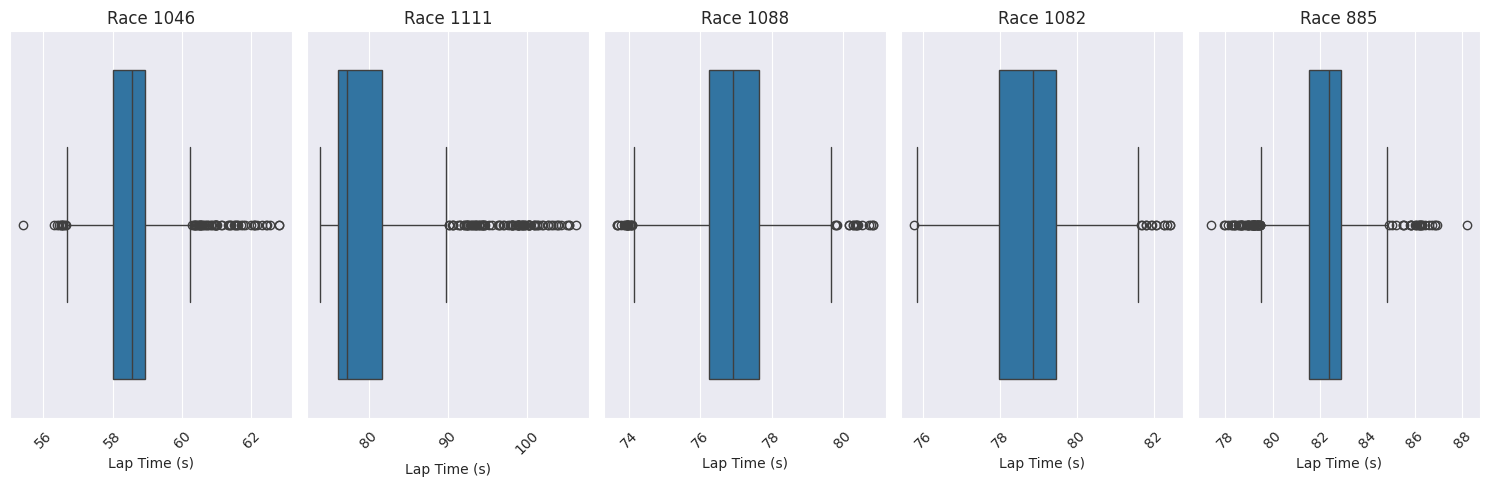

In [8]:
top_races = df1['raceId'].value_counts().index[:5]

plt.figure(figsize=(15, 5))
for i, race in enumerate(top_races, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(x=df1[df1['raceId'] == race]['lap_time'])
    plt.title(f'Race {race}')
    plt.xticks(rotation=45)
    plt.xlabel('Lap Time (s)')
plt.tight_layout()
plt.show()

In [9]:
# df1["lap"] = df1["lap"]/df1["total_laps"]

In [10]:
df1.head()

,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,no_of_stops,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef
0,0,841,20,1,1,91.3725,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
1,1,841,20,2,1,93.0060,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
2,2,841,20,3,1,92.7130,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
3,3,841,20,4,1,92.8030,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel
4,4,841,20,5,1,92.3420,9.0,1.0,1.0,85.296,...,NaN,NaN,1,58,5370.259,1,2011,1,Australian Grand Prix,vettel


In [11]:
!pwd

/home/ubuntu/f1-prediction/Codes


In [12]:
def fill_number_of_stops(df):
    df = df.sort_values(by=['raceId', 'driverId', 'lap']).copy()


    def process_group(group):
        group = group.sort_values("lap").copy()
        no_of_stops = 0
        pit_stop_duration = 0.0
        for idx in group.index:
            val = group.at[idx, "no_of_stops"]
            duration = group.at[idx, "pit_stop_duration"]

            if pd.notna(val):
                no_of_stops = int(val)
                pit_stop_duration = float(duration)
            else:
                group.at[idx, "no_of_stops"] = no_of_stops
                group.at[idx, "pit_stop_duration"] = pit_stop_duration
        return group

    return df.groupby(['raceId', 'driverId'], group_keys=False).apply(process_group)
df1 = fill_number_of_stops(df1)
df1.head(10)


/tmp/ipykernel_4964/487490436.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(['raceId', 'driverId'], group_keys=False).apply(process_group)


,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,no_of_stops,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef
161277,343094,1,2,1,17,91.7135,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161278,343095,1,2,2,17,97.6400,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161279,343096,1,2,3,17,91.6970,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161280,343097,1,2,4,17,91.8670,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161281,343098,1,2,5,17,92.2340,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161282,343099,1,2,6,17,92.0360,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161283,343100,1,2,7,17,91.6590,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161284,343101,1,2,8,17,91.8010,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161285,343102,1,2,9,17,93.4910,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161286,343103,1,2,10,17,93.0630,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld


In [13]:
df1.head(80)

,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,no_of_stops,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef
161277,343094,1,2,1,17,91.7135,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161278,343095,1,2,2,17,97.6400,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161279,343096,1,2,3,17,91.6970,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161280,343097,1,2,4,17,91.8670,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
161281,343098,1,2,5,17,92.2340,2.0,6.0,11.0,85.827,...,0.0,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161642,343596,1,3,18,9,93.1480,3.0,16.0,5.0,85.846,...,0.0,0.0,16,58,5661.506,1,2009,1,Australian Grand Prix,rosberg
161643,343597,1,3,19,7,90.8870,3.0,16.0,5.0,85.846,...,0.0,0.0,16,58,5661.506,1,2009,1,Australian Grand Prix,rosberg
161644,343598,1,3,20,6,90.8870,3.0,16.0,5.0,85.846,...,0.0,0.0,16,58,5661.506,1,2009,1,Australian Grand Prix,rosberg
161645,343599,1,3,21,6,90.8870,3.0,16.0,5.0,85.846,...,0.0,0.0,16,58,5661.506,1,2009,1,Australian Grand Prix,rosberg


In [14]:
df1.isnull().sum()

Unnamed: 0               0
raceId                   0
driverId                 0
lap                      0
lap_position             0
lap_time                 0
constructorId        32820
number               32820
quali_position       32820
q1                   32820
q2                   33081
q3                   33944
no_of_stops              0
pit_stop_duration        0
result_position          0
total_laps               0
total_time               0
statusId                 0
year                     0
round                    0
grand_prix_name          0
driverRef                0
dtype: int64

In [15]:
df1 = df1.dropna(subset=['constructorId'])
df1.shape

(271646, 22)

In [16]:
df1[['q1','q2','q3']] = df1[['q1','q2','q3']].replace('\\N', np.nan)
df1[['q1','q2','q3']] = df1[['q1','q2','q3']].astype(float)
df1['q1'] = df1['q1'].fillna(df1['q1'].mean())
df1['q2'] = df1['q2'].fillna(df1['q1'])
df1['q3'] = df1['q3'].fillna((df1['q1']+df1['q2'])/2)

/tmp/ipykernel_4964/4113606177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1[['q1','q2','q3']] = df1[['q1','q2','q3']].replace('\\N', np.nan)


<Axes: >

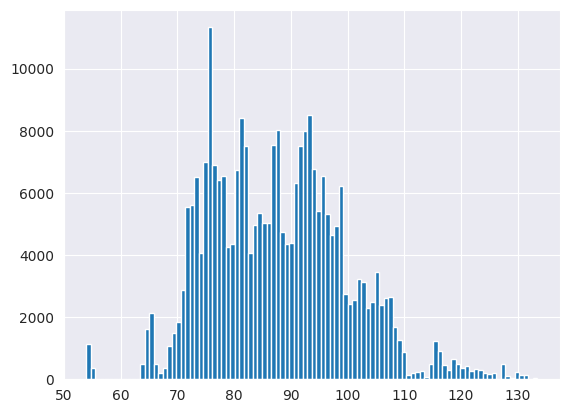

In [17]:
df1["q1"].hist(bins=100)

<Axes: >

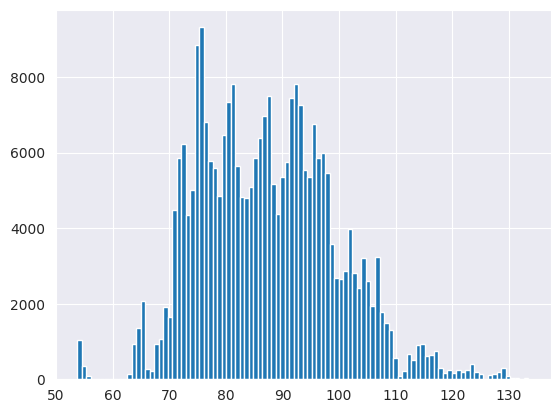

In [18]:
df1["q2"].hist(bins =100)

<Axes: >

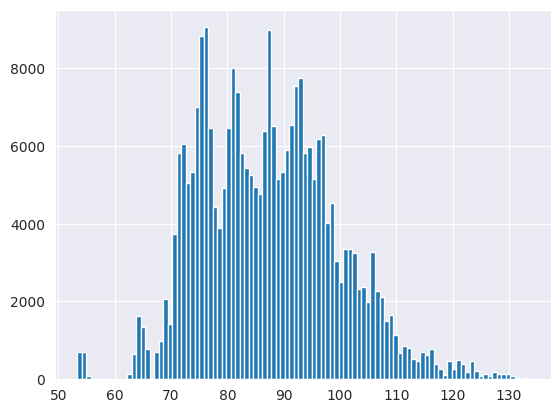

In [19]:
df1["q3"].hist(bins =100)

In [20]:
df1 = df1.replace('\\N', np.nan)
df1.isnull().sum()


Unnamed: 0           0
raceId               0
driverId             0
lap                  0
lap_position         0
lap_time             0
constructorId        0
number               0
quali_position       0
q1                   0
q2                   0
q3                   0
no_of_stops          0
pit_stop_duration    0
result_position      0
total_laps           0
total_time           0
statusId             0
year                 0
round                0
grand_prix_name      0
driverRef            0
dtype: int64

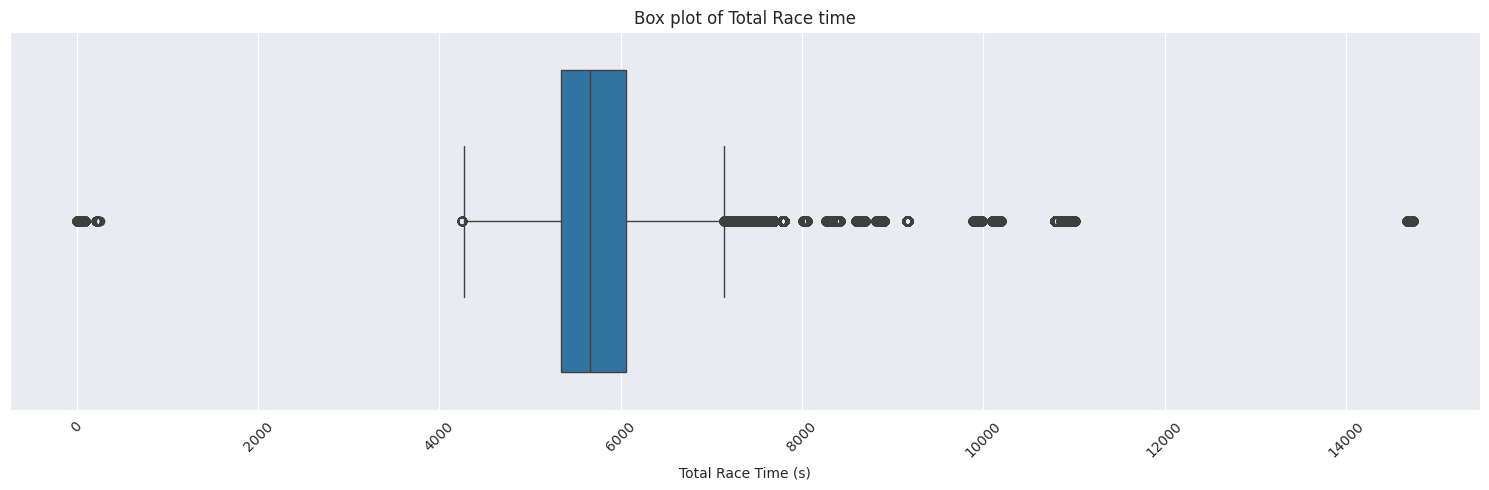

In [21]:
plt.figure(figsize=(15, 5))

sns.boxplot(x=df1["total_time"])
plt.title(f'Box plot of Total Race time')
plt.xticks(rotation=45)
plt.xlabel('Total Race Time (s)')
plt.tight_layout()
plt.show()

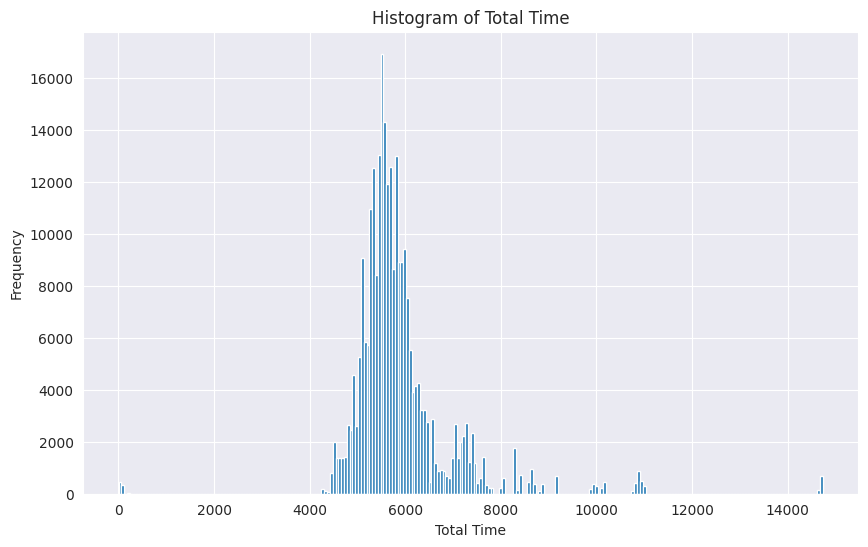

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df1["total_time"].hist(bins=250)
plt.title("Histogram of Total Time")
plt.xlabel("Total Time")
plt.ylabel("Frequency")
plt.show()


In [23]:
df1 = df1[(df1["total_time"]<8000) & (df1["total_time"]>4000)]

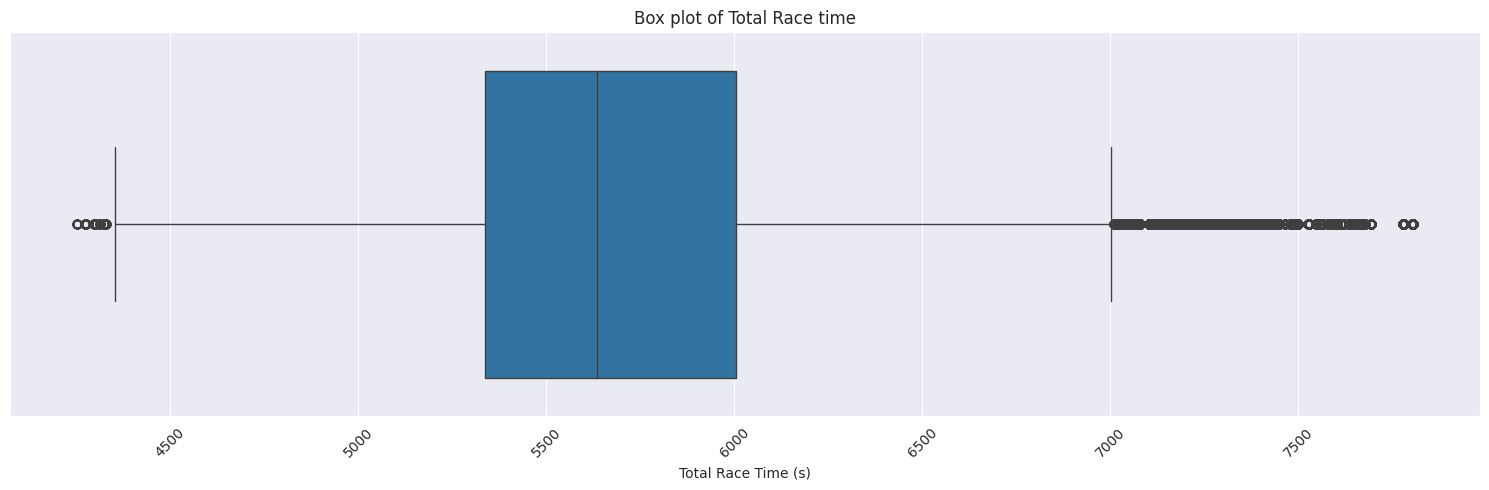

In [24]:
plt.figure(figsize=(15, 5))

sns.boxplot(x=df1["total_time"])
plt.title(f'Box plot of Total Race time')
plt.xticks(rotation=45)
plt.xlabel('Total Race Time (s)')
plt.tight_layout()
plt.show()

In [25]:
df1.columns

Index(['Unnamed: 0', 'raceId', 'driverId', 'lap', 'lap_position', 'lap_time',
       'constructorId', 'number', 'quali_position', 'q1', 'q2', 'q3',
       'no_of_stops', 'pit_stop_duration', 'result_position', 'total_laps',
       'total_time', 'statusId', 'year', 'round', 'grand_prix_name',
       'driverRef'],
      dtype='object')

In [26]:
import pandas as pd

# Assuming your DataFrame is called `df`
df2 = df1.sort_values(['raceId', 'driverId', 'lap']).copy()

# Initialize tyre age column
df2['tyre_age'] = 0

# Group by race and driver
for (race_id, driver_id), group in df2.groupby(['raceId', 'driverId']):
    tyre_age = 0
    last_stops = 0
    tyre_ages = []

    for _, row in group.iterrows():
        current_stops = row['no_of_stops']
        # Reset age if a new pit stop occurred
        if current_stops > last_stops:
            tyre_age = 1  # New tyre
        else:
            tyre_age += 1
        tyre_ages.append(tyre_age)
        last_stops = current_stops

    # Assign values back to the main dataframe
    df2.loc[group.index, 'tyre_age'] = tyre_ages


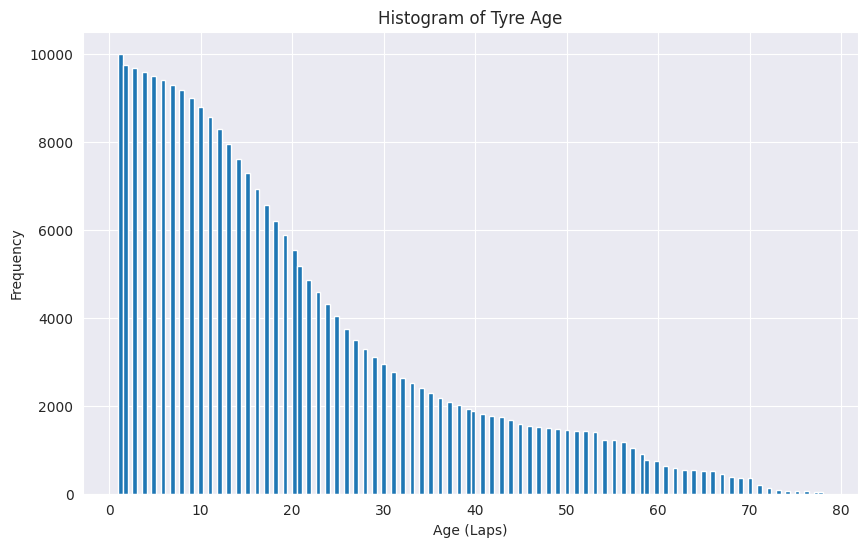

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
df2["tyre_age"].hist(bins=150)
plt.title("Histogram of Tyre Age")
plt.xlabel("Age (Laps)")
plt.ylabel("Frequency")
plt.show()

In [28]:
df2.columns

Index(['Unnamed: 0', 'raceId', 'driverId', 'lap', 'lap_position', 'lap_time',
       'constructorId', 'number', 'quali_position', 'q1', 'q2', 'q3',
       'no_of_stops', 'pit_stop_duration', 'result_position', 'total_laps',
       'total_time', 'statusId', 'year', 'round', 'grand_prix_name',
       'driverRef', 'tyre_age'],
      dtype='object')

In [35]:
FEATURES = ['lap', 'lap_position', 'lap_time','quali_position', 'q1', 'q2', 'q3', 'total_laps',
       'no_of_stops', 'pit_stop_duration', 'tyre_age']
TARGET = ['total_time']

In [36]:
df2.head()

,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef,tyre_age
161277,343094,1,2,1,17,91.7135,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,1
161278,343095,1,2,2,17,97.6400,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,2
161279,343096,1,2,3,17,91.6970,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,3
161280,343097,1,2,4,17,91.8670,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,4
161281,343098,1,2,5,17,92.2340,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,5


In [37]:
import statsmodels.api as sm
import pandas as pd
X = df2[FEATURES].copy()
y = df2[TARGET].copy()

# Optional: If any missing values exist
X = X.fillna(0)
y = y.fillna(0)

# Add a constant for intercept
X = sm.add_constant(X)
model_ols = sm.OLS(y, X).fit()
print(model_ols.summary())


                            OLS Regression Results                            
Dep. Variable:             total_time   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                 6.396e+04
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        12:00:04   Log-Likelihood:            -1.8759e+06
No. Observations:              259985   AIC:                         3.752e+06
Df Residuals:                  259973   BIC:                         3.752e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4372.3992     13.82

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import os

In [39]:
# === 1. Fit scalers ===
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit on data
feature_scaler.fit(df2[FEATURES])
target_scaler.fit(df2[TARGET])

# === 2. Save scalers ===
save_path = 'scalers_prod'
os.makedirs(save_path, exist_ok=True)

joblib.dump(feature_scaler, f'{save_path}/feature_scaler.save')
joblib.dump(target_scaler, f'{save_path}/target_scaler.save')

# === 3. Save stats for reference ===
feature_stats = pd.DataFrame({
    'feature': FEATURES,
    'mean': feature_scaler.mean_,
    'std': feature_scaler.scale_
})
feature_stats.to_csv(f'{save_path}/feature_stats.csv', index=False)

target_stats = pd.DataFrame({
    'target': TARGET,
    'mean': target_scaler.mean_,
    'std': target_scaler.scale_
})
target_stats.to_csv(f'{save_path}/target_stats.csv', index=False)

print("✅ Feature & target scalers and stats saved to:", save_path)
df1_scaled = df2.copy()
df1_scaled[FEATURES] = feature_scaler.transform(df1_scaled[FEATURES])
df1_scaled[TARGET] = target_scaler.transform(df1_scaled[TARGET])

✅ Feature & target scalers and stats saved to: scalers_prod


In [40]:
test_df = df1_scaled[df1_scaled["year"]==2024]
train_df = df1_scaled[df1_scaled["year"]!=2024]

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    train_df[FEATURES], train_df[TARGET], test_size=0.2, random_state=42
)

In [42]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((195516, 11), (48880, 11), (195516, 1), (48880, 1))

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert to PyTorch tensors (fix by adding `.values`)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device).view(-1, 1)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device).view(-1, 1)


# Create Dataloaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)


Using device: cuda


In [47]:
class RegressionNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 37),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(37, 42),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(42, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.model(x)

model = RegressionNet(input_dim=X_train.shape[1]).to(device)


Epoch 001 | Train Loss: 0.2622 | Val Loss: 0.1851
Epoch 002 | Train Loss: 0.1968 | Val Loss: 0.1578
Epoch 003 | Train Loss: 0.1779 | Val Loss: 0.1470
Epoch 004 | Train Loss: 0.1695 | Val Loss: 0.1382
Epoch 005 | Train Loss: 0.1642 | Val Loss: 0.1308
Epoch 006 | Train Loss: 0.1597 | Val Loss: 0.1332
Epoch 007 | Train Loss: 0.1555 | Val Loss: 0.1266
Epoch 008 | Train Loss: 0.1538 | Val Loss: 0.1290
Epoch 009 | Train Loss: 0.1525 | Val Loss: 0.1294
Epoch 010 | Train Loss: 0.1507 | Val Loss: 0.1286
Epoch 011 | Train Loss: 0.1501 | Val Loss: 0.1269
Epoch 012 | Train Loss: 0.1488 | Val Loss: 0.1240
Epoch 013 | Train Loss: 0.1479 | Val Loss: 0.1251
Epoch 014 | Train Loss: 0.1464 | Val Loss: 0.1258
Epoch 015 | Train Loss: 0.1460 | Val Loss: 0.1225
Epoch 016 | Train Loss: 0.1451 | Val Loss: 0.1250
Epoch 017 | Train Loss: 0.1444 | Val Loss: 0.1259
Epoch 018 | Train Loss: 0.1441 | Val Loss: 0.1276
Epoch 019 | Train Loss: 0.1431 | Val Loss: 0.1272
Epoch 020 | Train Loss: 0.1419 | Val Loss: 0.1227


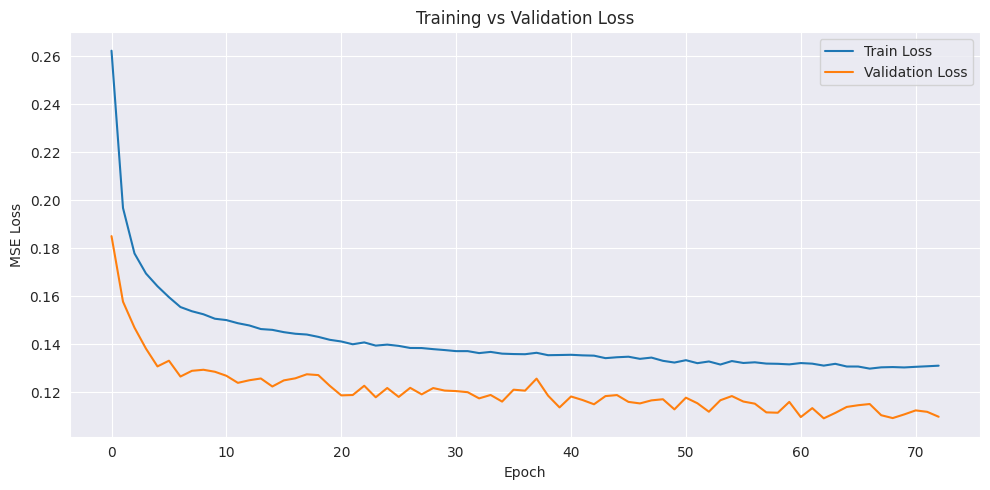

In [48]:
import matplotlib.pyplot as plt

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 100
best_val_loss = float('inf')
early_stop_counter = 0

# Store losses for plotting
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)

    # Store for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "regression_model.pt")
    else:
        early_stop_counter += 1
        if early_stop_counter >= 10:
            print("Early stopping triggered.")
            break

# --- 🔍 Plot loss curves ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
X_test = test_df[FEATURES]
y_test = test_df[TARGET]
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device).view(-1, 1)

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load best model weights
model.load_state_dict(torch.load("regression_model.pt"))
model.eval()

# Make predictions
with torch.no_grad():
    preds = model(X_test_tensor).cpu().numpy()
    targets = y_test_tensor.cpu().numpy()

# Metrics
mse = mean_squared_error(targets, preds)
mae = mean_absolute_error(targets, preds)
r2 = r2_score(targets, preds)

print(f"📊 Test MSE: {mse:.4f}")
print(f"📊 Test MAE: {mae:.4f}")
print(f"📊 Test R² Score: {r2:.4f}")


📊 Test MSE: 0.4900
📊 Test MAE: 0.4402
📊 Test R² Score: 0.6467


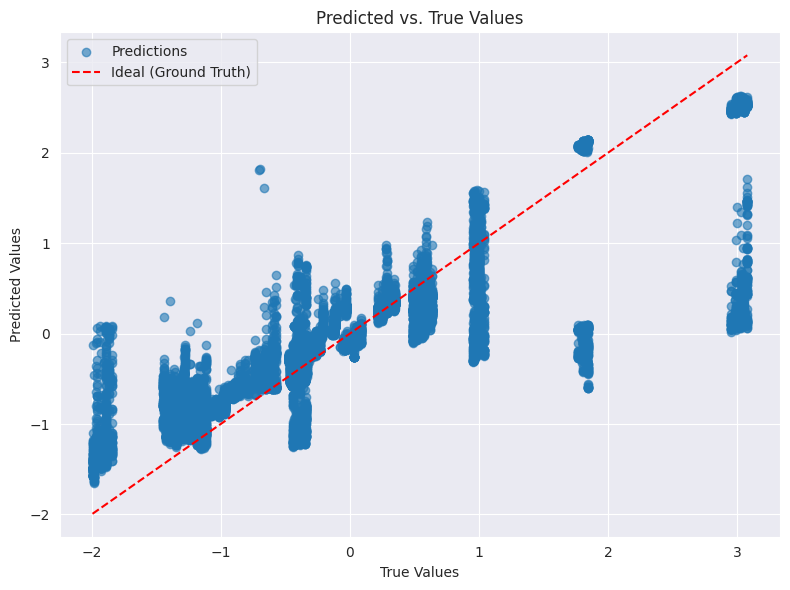

In [51]:
true_vals = y_test_tensor.cpu().numpy().flatten()
pred_vals = model(X_test_tensor).detach().cpu().numpy().flatten()

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_vals, pred_vals, alpha=0.6, label="Predictions")
plt.plot([true_vals.min(), true_vals.max()],
         [true_vals.min(), true_vals.max()],
         'r--', label="Ideal (Ground Truth)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [258]:
test_df.head()

,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef,tyre_age
287995,562963,1121,1,-1.700534,0.498724,0.387216,131.0,44.0,0.24598,0.230649,...,0.0,1.341294,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-1.163670
287996,562964,1121,1,-1.639757,0.498724,0.512477,131.0,44.0,0.24598,0.230649,...,0.0,1.341294,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-1.100842
287997,562965,1121,1,-1.578979,0.498724,0.514857,131.0,44.0,0.24598,0.230649,...,0.0,1.341294,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-1.038014
287998,562966,1121,1,-1.518202,0.498724,0.513587,131.0,44.0,0.24598,0.230649,...,0.0,1.341294,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-0.975187
287999,562967,1121,1,-1.457424,0.498724,0.518585,131.0,44.0,0.24598,0.230649,...,0.0,1.341294,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-0.912359


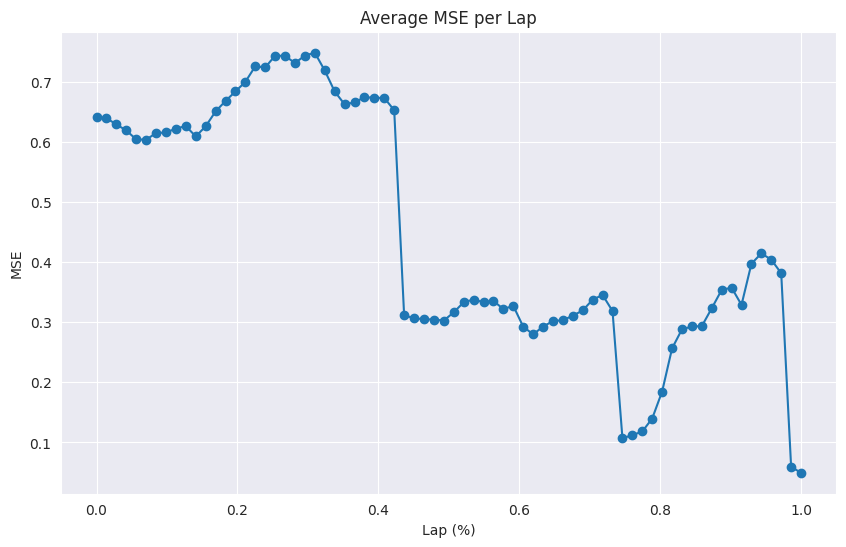

In [55]:
lap_list = sorted(test_df['lap'].unique())
lap_mse = []

for lap in lap_list:
    lap_df = test_df[test_df['lap'] == lap].copy()

    # Extract and scale features
    X_lap = lap_df[FEATURES].values.astype(np.float32)
    y_lap = lap_df[TARGET].values.astype(np.float32)

    # # Optional: scale if needed
    # if 'feature_scaler' in globals():
    #     X_lap = feature_scaler.transform(X_lap)
    # if 'target_scaler' in globals():
    #     y_lap = target_scaler.transform(y_lap)

    # Convert to tensor
    X_tensor = torch.tensor(X_lap, dtype=torch.float32).to(device)
    y_true = y_lap

    # Predict
    with torch.no_grad():
        y_pred = model(X_tensor).cpu().numpy()

    # Optional: inverse transform prediction
    # if 'target_scaler' in globals():
    #     y_pred = target_scaler.inverse_transform(y_pred)
    #     y_true = target_scaler.inverse_transform(y_true)

    mse = mean_squared_error(y_true, y_pred)
    lap_mse.append(mse)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 1, len(lap_mse)), lap_mse, marker='o')
plt.title("Average MSE per Lap")
plt.xlabel("Lap (%)")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

In [58]:
df2.head()

,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef,tyre_age
161277,343094,1,2,1,17,91.7135,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,1
161278,343095,1,2,2,17,97.6400,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,2
161279,343096,1,2,3,17,91.6970,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,3
161280,343097,1,2,4,17,91.8670,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,4
161281,343098,1,2,5,17,92.2340,2.0,6.0,11.0,85.827,...,0.0,6,58,5662.869,1,2009,1,Australian Grand Prix,heidfeld,5


In [60]:
df2.columns

Index(['Unnamed: 0', 'raceId', 'driverId', 'lap', 'lap_position', 'lap_time',
       'constructorId', 'number', 'quali_position', 'q1', 'q2', 'q3',
       'no_of_stops', 'pit_stop_duration', 'result_position', 'total_laps',
       'total_time', 'statusId', 'year', 'round', 'grand_prix_name',
       'driverRef', 'tyre_age'],
      dtype='object')

In [61]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


In [82]:
FEATURES = ['lap', 'lap_position', 'quali_position', 'q1', 'q2', 'q3', 'no_of_stops', 'pit_stop_duration', 'total_laps', 'tyre_age','lap_time']
TARGET = ['total_time']
# === 1. Fit scalers ===
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit on data
feature_scaler.fit(df2[FEATURES])
target_scaler.fit(df2[TARGET])

# === 2. Save scalers ===
save_path = 'scalers_prod'
os.makedirs(save_path, exist_ok=True)

joblib.dump(feature_scaler, f'{save_path}/feature_scaler_2.save')
joblib.dump(target_scaler, f'{save_path}/target_scaler_2.save')

# === 3. Save stats for reference ===
feature_stats = pd.DataFrame({
    'feature': FEATURES,
    'mean': feature_scaler.mean_,
    'std': feature_scaler.scale_
})
feature_stats.to_csv(f'{save_path}/feature_stats.csv', index=False)

target_stats = pd.DataFrame({
    'target': TARGET,
    'mean': target_scaler.mean_,
    'std': target_scaler.scale_
})
target_stats.to_csv(f'{save_path}/target_stats.csv', index=False)

print("✅ Feature & target scalers and stats saved to:", save_path)
df2_scaled = df2.copy()
df2_scaled[FEATURES] = feature_scaler.transform(df2_scaled[FEATURES])
df2_scaled[TARGET] = target_scaler.transform(df2_scaled[TARGET])

✅ Feature & target scalers and stats saved to: scalers_prod


In [135]:
class RaceDataset(Dataset):
    def __init__(self, df, sequence_length=10):
        self.seq_len = sequence_length
        self.samples = []

        grouped = df.groupby(['raceId', 'driverId'])
        for (race_id, driver_id), group in grouped:
            group = group.sort_values('lap')
            if len(group) >= sequence_length:
                for i in range(sequence_length, len(group)):
                    lap_sequence = group.iloc[i-sequence_length:i]['lap_time'].values.astype(np.float32)
                    static_features = group.iloc[i][[
                        'lap', 'lap_position', 'quali_position',
                        'q1', 'q2', 'q3', 'no_of_stops', 'pit_stop_duration',
                        'total_laps', 'tyre_age'
                    ]].values.astype(np.float32)
                    total_time = group.iloc[i]['total_time']
                    self.samples.append((lap_sequence, static_features, total_time))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        lap_seq, static_feat, target = self.samples[idx]
        return torch.tensor(lap_seq), torch.tensor(static_feat), torch.tensor(target, dtype=torch.float32)


In [136]:
class LSTMWithStatic(nn.Module):
    def __init__(self, lstm_input=1, lstm_hidden=32, static_input=10):
        super().__init__()
        self.lstm = nn.LSTM(input_size=lstm_input, hidden_size=lstm_hidden, batch_first=True)
        self.fc_lstm = nn.Linear(lstm_hidden, 2)
        self.fc_final = nn.Sequential(
            nn.Linear(2 + static_input, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, seq_input, static_input):
        seq_input = seq_input.unsqueeze(-1)  # (B, T) -> (B, T, 1)
        _, (h_n, _) = self.lstm(seq_input)
        lstm_out = self.fc_lstm(h_n[-1])  # (B, 2)
        combined = torch.cat([lstm_out, static_input], dim=1)
        return self.fc_final(combined).squeeze(1)


In [137]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import torch

def train_model(df, model_save_path="best_lstm_model.pt", patience=10, max_epochs=100):
    dataset = RaceDataset(df)
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64)

    model = LSTMWithStatic()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        train_loss = 0
        for seq, stat, target in train_loader:
            optimizer.zero_grad()
            pred = model(seq, stat)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(seq)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for seq, stat, target in val_loader:
                pred = model(seq, stat)
                loss = criterion(pred, target)
                val_loss += loss.item() * len(seq)
                all_preds.append(pred)
                all_targets.append(target)
        val_loss /= len(val_loader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # --- Save Best Model ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print("✅ Saved best model!")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    # Final Evaluation
    model.load_state_dict(torch.load(model_save_path))  # Load best model
    model.eval()
    with torch.no_grad():
        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()
    print(f"\nFinal R² Score: {r2_score(all_targets, all_preds):.4f}")
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    print(f"Final RMSE: {rmse:.4f}")

    # 📈 Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
train_model(df2_scaled.copy())

In [77]:
df2_scaled.head()

,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef,tyre_age
161277,343094,1,2,-1.783417,-0.996279,-7.284081,2.0,6.0,-1.354223,-7.223146,...,-0.193737,6,-7.07575,-9.064303,1,2009,1,Australian Grand Prix,heidfeld,-1.299608
161278,343095,1,2,-1.780421,-0.996279,-7.246784,2.0,6.0,-1.354223,-7.223146,...,-0.193737,6,-7.07575,-9.064303,1,2009,1,Australian Grand Prix,heidfeld,-1.295661
161279,343096,1,2,-1.777424,-0.996279,-7.284184,2.0,6.0,-1.354223,-7.223146,...,-0.193737,6,-7.07575,-9.064303,1,2009,1,Australian Grand Prix,heidfeld,-1.291714
161280,343097,1,2,-1.774428,-0.996279,-7.283115,2.0,6.0,-1.354223,-7.223146,...,-0.193737,6,-7.07575,-9.064303,1,2009,1,Australian Grand Prix,heidfeld,-1.287766
161281,343098,1,2,-1.771431,-0.996279,-7.280805,2.0,6.0,-1.354223,-7.223146,...,-0.193737,6,-7.07575,-9.064303,1,2009,1,Australian Grand Prix,heidfeld,-1.283819


In [89]:
test_df = df2[df2["year"] == 2024]
test_df_scaled = test_df.copy()
test_df_scaled[FEATURES] = feature_scaler.transform(test_df_scaled[FEATURES])
test_df_scaled[TARGET] = target_scaler.transform(test_df_scaled[TARGET])


📌 Test Metrics:
✅ MSE      : 0.1124
✅ MAE      : 0.2381
✅ RMSE     : 0.3353
✅ R² Score : 0.9192


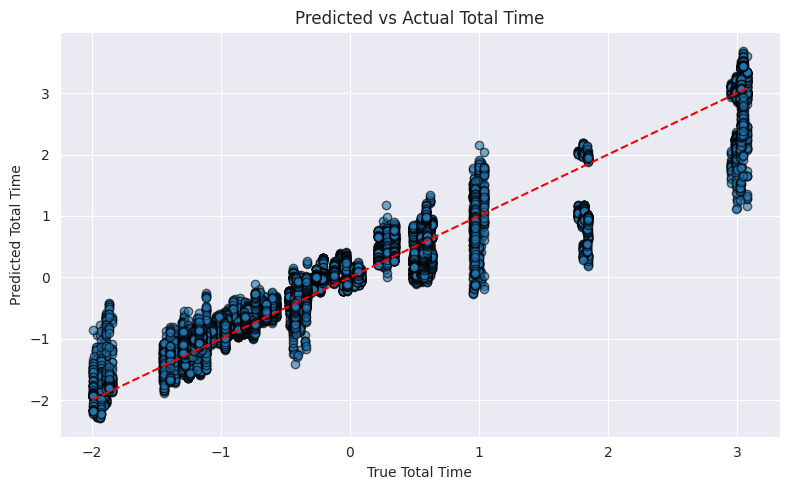

In [91]:
def test_model(test_df, model_path="best_lstm_model.pt"):
    import torch
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

    # Dataset and loader
    test_dataset = RaceDataset(test_df)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Load model
    model = LSTMWithStatic()
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Inference
    all_preds, all_targets = [], []
    with torch.no_grad():
        for seq, stat, target in test_loader:
            pred = model(seq, stat)
            all_preds.append(pred)
            all_targets.append(target)

    # Concatenate
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    # 📊 Metrics
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    # rmse = mean_squared_error(all_targets, all_preds, squared=False)
    r2 = r2_score(all_targets, all_preds)

    print("\n📌 Test Metrics:")
    print(f"✅ MSE      : {mse:.4f}")
    print(f"✅ MAE      : {mae:.4f}")
    print(f"✅ RMSE     : {rmse:.4f}")
    print(f"✅ R² Score : {r2:.4f}")

    # 📈 Plot Predictions vs Ground Truth
    plt.figure(figsize=(8, 5))
    plt.scatter(all_targets, all_preds, alpha=0.6, edgecolor='k')
    plt.plot([all_targets.min(), all_targets.max()],
             [all_targets.min(), all_targets.max()], 'r--')
    plt.xlabel("True Total Time")
    plt.ylabel("Predicted Total Time")
    plt.title("Predicted vs Actual Total Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
test_model(test_df_scaled)


In [97]:
test_df_scaled

,Unnamed: 0,raceId,driverId,lap,lap_position,lap_time,constructorId,number,quali_position,q1,...,pit_stop_duration,result_position,total_laps,total_time,statusId,year,round,grand_prix_name,driverRef,tyre_age
287995,562963,1121,1,-1.638962,0.498724,0.387216,131.0,44.0,0.245980,0.230649,...,-0.192602,44,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-1.163670
287996,562964,1121,1,-1.584222,0.498724,0.512477,131.0,44.0,0.245980,0.230649,...,-0.192602,44,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-1.100842
287997,562965,1121,1,-1.529483,0.498724,0.514857,131.0,44.0,0.245980,0.230649,...,-0.192602,44,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-1.038014
287998,562966,1121,1,-1.474744,0.498724,0.513587,131.0,44.0,0.245980,0.230649,...,-0.192602,44,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-0.975187
287999,562967,1121,1,-1.420004,0.498724,0.518585,131.0,44.0,0.245980,0.230649,...,-0.192602,44,-0.448363,-0.296732,1,2024,1,Bahrain Grand Prix,hamilton,-0.912359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304461,589076,1144,857,1.262227,0.721127,-0.323813,1.0,81.0,-1.092025,-0.329697,...,0.000637,81,-0.332768,-0.735417,1,2024,24,Abu Dhabi Grand Prix,piastri,0.218539
304462,589077,1144,857,1.316966,0.721127,-0.319847,1.0,81.0,-1.092025,-0.329697,...,0.000637,81,-0.332768,-0.735417,1,2024,24,Abu Dhabi Grand Prix,piastri,0.281367
304463,589078,1144,857,1.371705,0.721127,-0.317070,1.0,81.0,-1.092025,-0.329697,...,0.000637,81,-0.332768,-0.735417,1,2024,24,Abu Dhabi Grand Prix,piastri,0.344195
304464,589079,1144,857,1.426445,0.721127,-0.258525,1.0,81.0,-1.092025,-0.329697,...,0.000637,81,-0.332768,-0.735417,1,2024,24,Abu Dhabi Grand Prix,piastri,0.407022


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


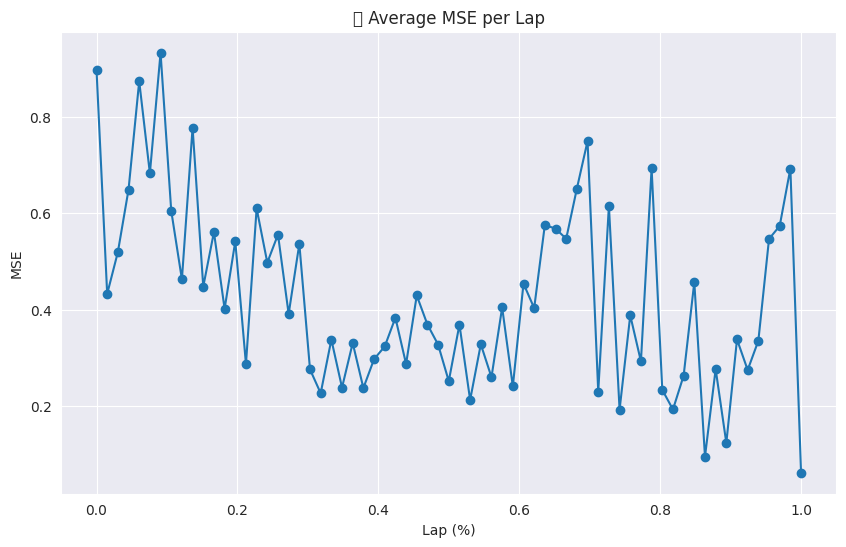

In [104]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

# Setup
lap_list = sorted(test_df_scaled['lap'].unique())
lap_mse = []

# Load model
model = LSTMWithStatic()
model.load_state_dict(torch.load("best_lstm_model.pt"))
model.eval()

# Loop through laps
for lap in lap_list:
    lap_df = test_df_scaled[test_df_scaled['lap'] == lap].copy()
    total_laps = test_df_scaled[test_df_scaled['lap'] == lap]["total_laps"]
    # Skip if we don't have enough laps before this one
    if lap < -1.420004:
        continue

    # Prepare sequences (last 5 laps) and static features
    seq_inputs = []
    static_inputs = []
    targets = []
    for driver_id in lap_df['driverId'].unique():
        # Get last 5 laps for this driver
        driver_laps = test_df_scaled[(test_df_scaled['driverId'] == driver_id) & (test_df_scaled['lap'] <= lap)]
        if len(driver_laps) < 5:
            continue
        driver_laps = driver_laps.sort_values('lap').iloc[-5:]

        seq = driver_laps['lap_time'].values.astype(np.float32)
        static = driver_laps.iloc[-1][[
                        'lap', 'lap_position', 'quali_position',
                        'q1', 'q2', 'q3', 'no_of_stops', 'pit_stop_duration',
                        'total_laps', 'tyre_age'
                    ]].values.astype(np.float32)
        target = driver_laps.iloc[-1]['total_time']

        seq_inputs.append(seq)
        static_inputs.append(static)
        targets.append(target)

    if len(seq_inputs) == 0:
        continue

    # Convert to tensors
    seq_tensor = torch.tensor(seq_inputs) #.unsqueeze(-1)  # shape: [B, 5, 1]
    static_tensor = torch.tensor(static_inputs)
    target_tensor = torch.tensor(targets)

    # Predict
    with torch.no_grad():
        preds = model(seq_tensor, static_tensor).squeeze().numpy()

    # Compute MSE
    mse = mean_squared_error(targets, preds)
    lap_mse.append((lap/total_laps, mse))

# 📈 Plot
laps_percent = np.linspace(0, 1, len(lap_mse))
mse_vals = [m[1] for m in lap_mse]

plt.figure(figsize=(10, 6))
plt.plot(laps_percent, mse_vals, marker='o')
plt.title("📊 Average MSE per Lap")
plt.xlabel("Lap (%)")
plt.ylabel("MSE")
plt.grid(True)
plt.show()


In [118]:
predict_df = df2[df2["year"]==2024]
print(predict_df["raceId"].unique())
predict_df  = predict_df[predict_df["raceId"]==1121]

[1121 1122 1123 1124 1125 1126 1127 1129 1130 1131 1132 1133 1135 1136
 1137 1138 1139 1140 1141 1142 1143 1144]


In [121]:
def predict_lap_ranks(df: pd.DataFrame, model_path: str,
                      feature_scaler: StandardScaler, target_scaler: StandardScaler,
                      laps_to_predict: List[int] = [6, 15, 25,30]) -> pd.DataFrame:
    """
    Predicts driver rankings based on total race time using an LSTM + DNN model for specific laps.

    Args:
        df (pd.DataFrame): Scaled race data of a particular event.
        model_path (str): Path to the trained model file (.pt).
        feature_scaler (StandardScaler): Scaler used for features.
        target_scaler (StandardScaler): Scaler used for target (total_time).
        laps_to_predict (List[int]): Laps to perform prediction on.

    Returns:
        pd.DataFrame: DataFrame with driverId, lap, actual_total_time, predicted_total_time,
                      actual_rank, and predicted_rank.
    """
    model = LSTMWithStatic().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    results = []

    for lap in laps_to_predict:
        lap_df = df[df['lap'] == lap].copy()
        if lap < 5:
            continue

        seq_inputs, static_inputs, targets, driver_ids = [], [], [], []

        for driver_id in lap_df['driverId'].unique():
            driver_laps = df[(df['driverId'] == driver_id) & (df['lap'] <= lap)].sort_values('lap')
            if len(driver_laps) < 5:
                continue
            last_5_laps = driver_laps.iloc[-5:]

            # Sequential input (lap_time)
            seq = last_5_laps['lap_time'].values.astype(np.float32)
            seq_inputs.append(seq)

            # Static features
            static_feats = last_5_laps.iloc[-1][[
                'lap', 'lap_position', 'quali_position',
                'q1', 'q2', 'q3', 'no_of_stops',
                'pit_stop_duration', 'total_laps', 'tyre_age'
            ]].values.astype(np.float32)
            static_inputs.append(static_feats)

            # True target
            targets.append(last_5_laps.iloc[-1]['total_time'])
            driver_ids.append(driver_id)

        if not seq_inputs:
            continue

        # Convert to tensors
        seq_tensor = torch.tensor(seq_inputs).to(device)       # [B, 5, 1]
        static_tensor = torch.tensor(static_inputs).to(device)

        # Predict
        with torch.no_grad():
            preds_scaled = model(seq_tensor, static_tensor).squeeze().cpu().numpy()

        # Inverse transform predictions and true targets
        preds = target_scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        true_vals = target_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

        # Create temp df for ranking
        lap_result = pd.DataFrame({
            'driverId': driver_ids,
            'lap': lap,
            'actual_total_time': true_vals,
            'predicted_total_time': preds
        })

        # Compute rankings (lower time = better rank)
        lap_result['actual_rank'] = lap_result['actual_total_time'].rank(method='min')
        lap_result['predicted_rank'] = lap_result['predicted_total_time'].rank(method='min')

        results.append(lap_result)

    return pd.concat(results, ignore_index=True)


In [123]:
results = predict_lap_ranks(predict_df, "best_lstm_model.pt", feature_scaler, target_scaler)

In [132]:
import matplotlib.pyplot as plt
import random

def plot_rank_shift_with_actual(results_df: pd.DataFrame, laps_to_predict: List[int] = [6, 15, 25]):
    """
    Plots predicted and actual rank shifts over time for each driver.
    DriverIds sorted by actual rank at the final lap.
    """
    pivot_pred = results_df.pivot(index='driverId', columns='lap', values='predicted_rank')
    pivot_actual = results_df.pivot(index='driverId', columns='lap', values='actual_rank')

    final_lap = laps_to_predict[-1]
    sorted_driver_ids = pivot_actual[final_lap].sort_values().index.tolist()

    plt.figure(figsize=(12, len(sorted_driver_ids) * 0.4))
    ax = plt.gca()

    for driver_id in sorted_driver_ids:
        pred_ranks = pivot_pred.loc[driver_id]
        actual_ranks = pivot_actual.loc[driver_id]

        # Plot predicted rank line
        ax.plot(laps_to_predict, pred_ranks, marker='o', label=f'{driver_id}', linewidth=2)

        # Plot actual rank as X markers
        ax.plot(laps_to_predict, actual_ranks, 'x', color='white', markersize=6, linewidth=1)

        # Label driverId on the left side (based on actual rank at lap 6)
        start_rank = pred_ranks[laps_to_predict[0]]
        ax.text(laps_to_predict[0] - 0.8, start_rank, str(driver_id), va='center', fontsize=8, fontweight='bold', color='white')

    # Rank 1 at the top
    ax.invert_yaxis()
    ax.set_yticks(range(1, int(results_df['actual_rank'].max()) + 1))
    ax.set_xticks(laps_to_predict)
    ax.set_xlabel("Lap")
    ax.set_ylabel("Rank (1 is best)")
    ax.set_title("🎯 Predicted vs Actual Rank Over Laps")
    ax.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4964/2478524128.py:40: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


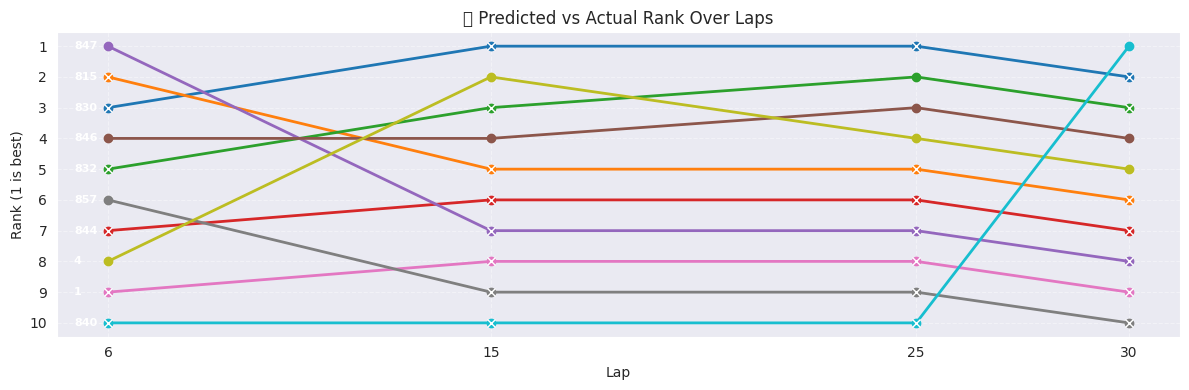

In [133]:
plot_rank_shift_with_actual(results, laps_to_predict=[6, 15, 25, 30])

In [134]:
results

,driverId,lap,actual_total_time,predicted_total_time,actual_rank,predicted_rank
0,1,6,3.525470e+06,62747.035156,7.0,9.0
1,4,6,3.541034e+06,62700.105469,9.0,8.0
2,815,6,3.507814e+06,62351.660156,2.0,2.0
3,830,6,3.493585e+06,62378.062500,1.0,3.0
4,832,6,3.509495e+06,62502.914062,3.0,5.0
5,840,6,3.552647e+06,63146.054688,10.0,10.0
6,844,6,3.518719e+06,62646.890625,4.0,7.0
7,846,6,3.524288e+06,62405.671875,6.0,4.0
8,847,6,3.523230e+06,62315.046875,5.0,1.0
9,857,6,3.529119e+06,62520.722656,8.0,6.0
